In [1]:
from pathlib import Path

import pandas as pd
import utils
from utils import ImposterGame

In [2]:
ckpt_path = Path("checkpoints/best.ckpt")
schedule_encoder_path = Path("checkpoints/schedule_encoder.pkl")
attributes_encoder_path = Path("checkpoints/attribute_encoder.pkl")

observed_path = Path("../examples/tmp/nts_schedules.csv")
observed = pd.read_csv(observed_path)

generator = utils.Generator(
    ckpt_path, schedule_encoder_path, attributes_encoder_path
)

/Users/fredshone/miniforge3/envs/caveat/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.1


Using teacher forcing ratio: 0.5
Using KLD weight: 0.001
Using duration weight: 1.0
Using mask: True
Using weighted loss: True


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Imposter Demo

The imposter game shows you 4 activity schedules; 3 from the UK NTS (2021) and one caveat synthetic activity schedule. Can you guess which one is synthetic? 

Restoring states from the checkpoint path at checkpoints/best.ckpt
/Users/fredshone/miniforge3/envs/caveat/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.1
Loaded model weights from the checkpoint at checkpoints/best.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

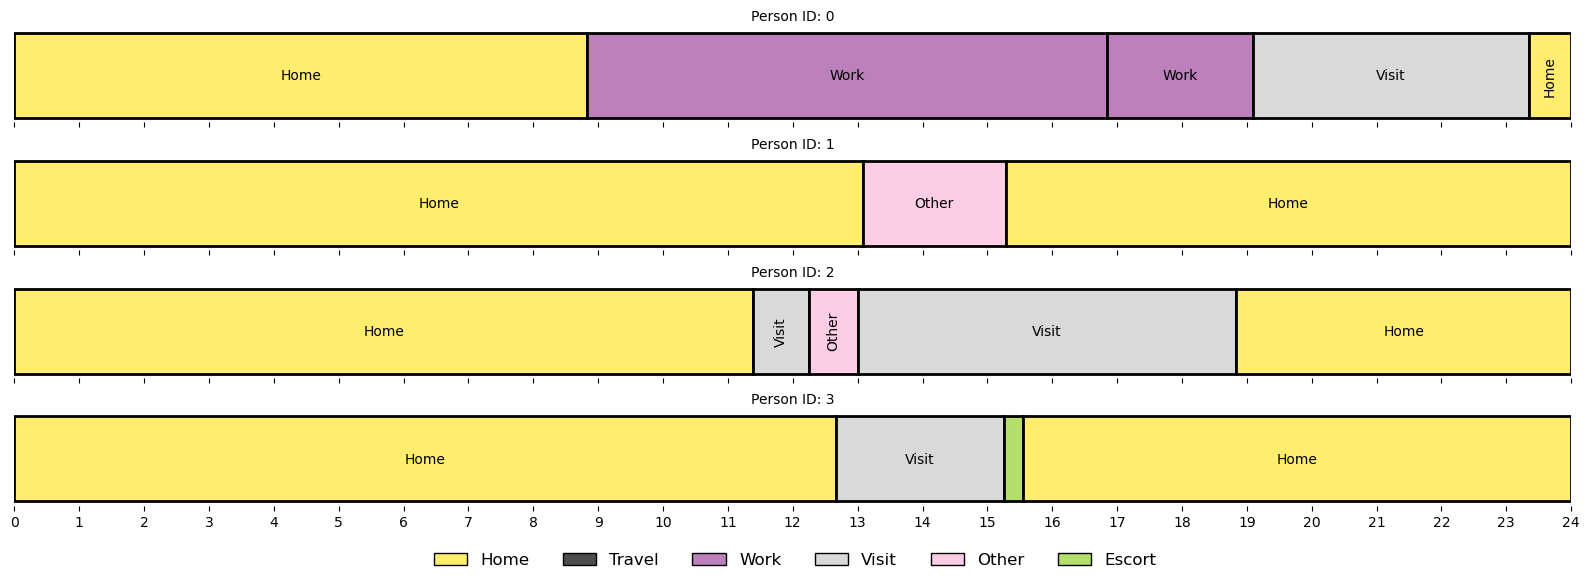

In [21]:
game = ImposterGame(generator, observed, 3)

In [20]:
game.guess(3)

Wrong! Correct answer is: 4


## Part 2...

### Conditionality

Restoring states from the checkpoint path at checkpoints/best.ckpt
/Users/fredshone/miniforge3/envs/caveat/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.1
Loaded model weights from the checkpoint at checkpoints/best.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

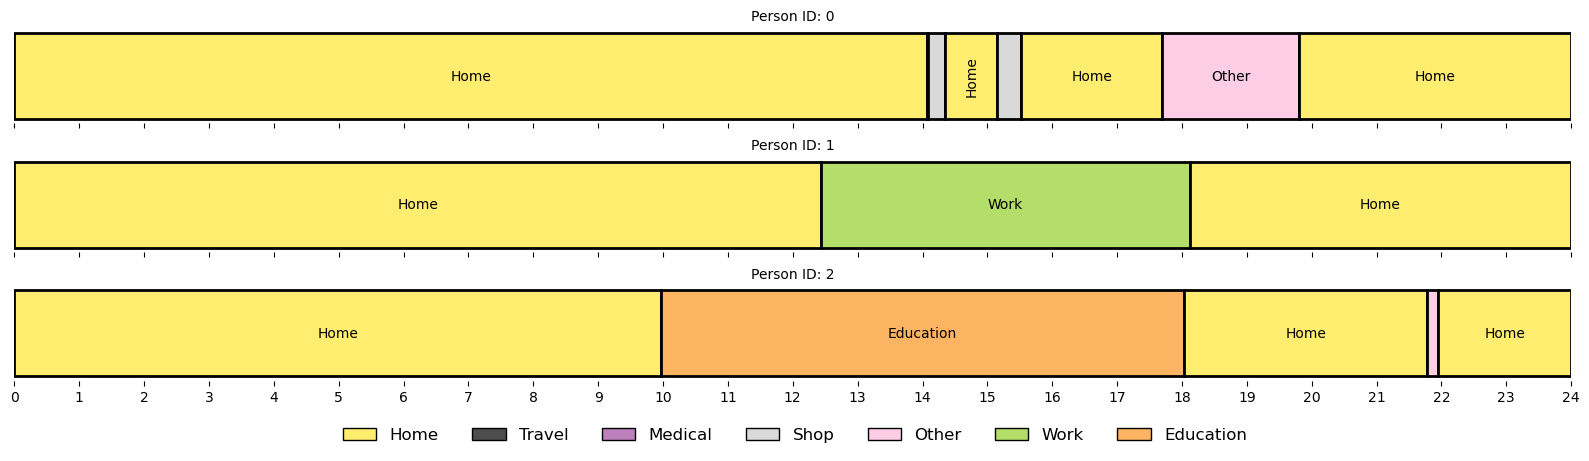

In [5]:
synthetics = pd.DataFrame(
    [
        {"gender": "F", "age": 30, "income": 4, "area": "suburban"},
        {"gender": "F", "age": 40, "income": 4, "area": "suburban"},
        {"gender": "F", "age": 50, "income": 4, "area": "suburban"},
    ]
)
utils.plot(generator(synthetics))

### Diversity

Restoring states from the checkpoint path at checkpoints/best.ckpt
/Users/fredshone/miniforge3/envs/caveat/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.1
Loaded model weights from the checkpoint at checkpoints/best.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

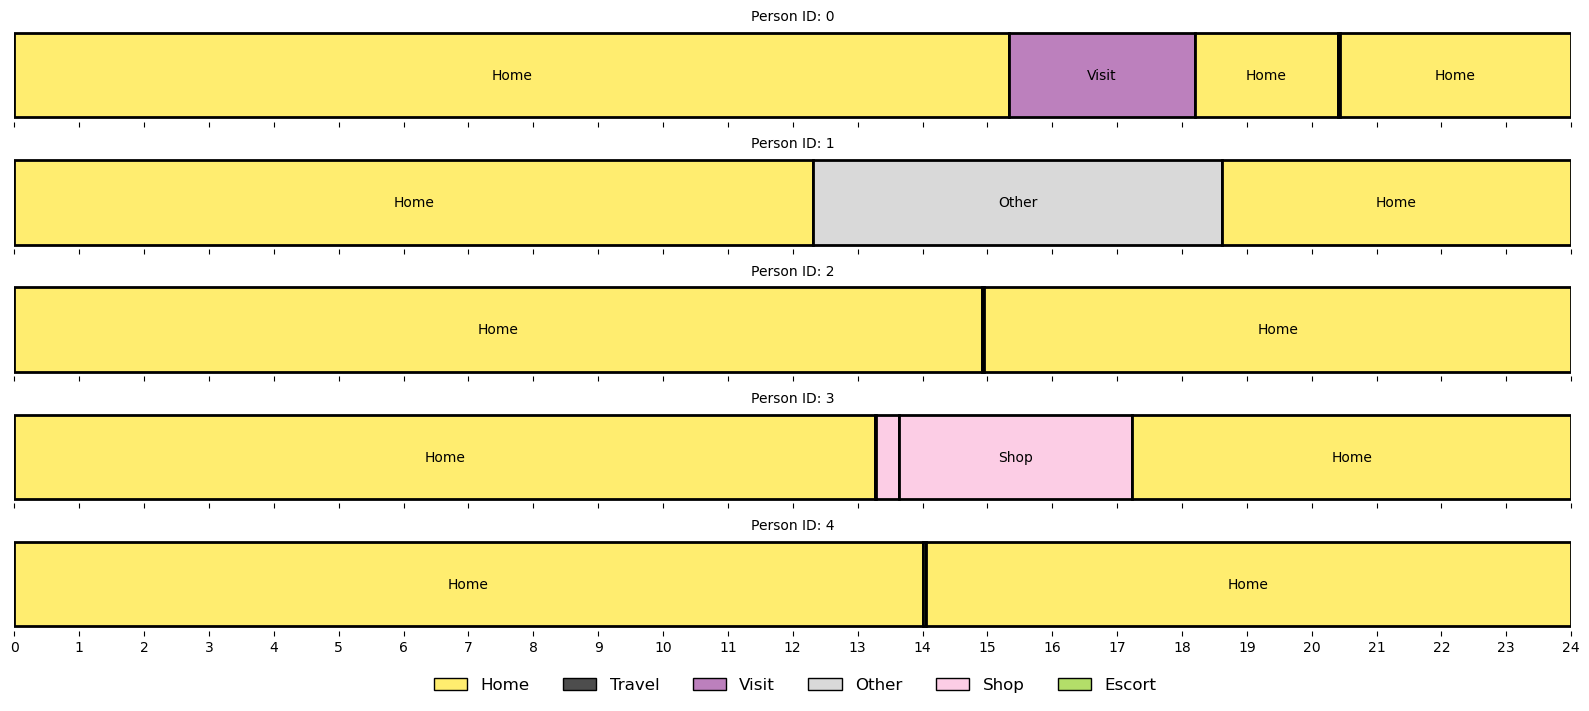

In [6]:
synthetics = pd.DataFrame(
    [{"gender": "M", "age": 30, "income": 2, "area": "urban"}] * 5
)

schedules = generator(synthetics)
utils.plot(schedules)

### Scale

In [7]:
synthetics = pd.DataFrame(
    [
        {"gender": "F", "age": 20, "income": 1, "area": "rural"}
        for _ in range(10_000)
    ]
)

population = generator._gen(synthetics)
print("Done")

Restoring states from the checkpoint path at checkpoints/best.ckpt
/Users/fredshone/miniforge3/envs/caveat/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.1
Loaded model weights from the checkpoint at checkpoints/best.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Done


In [8]:
population.tail()

,pid,act,start,end,duration
38669,9998,visit,1308,1371,63
38670,9998,home,1371,1427,56
38671,9999,home,0,906,906
38672,9999,other,906,907,1
38673,9999,home,907,1427,520
